## Cleaning FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine = pudl.db_connect_pudl()

## Define a function to clean data frames: What kind of errors are we fixing? Why is this kind of function a reasonable thing to do?
Looking at some of the distributions of the data below, it becomes clear immediately that there are the data was originally entered in a variety of ways. 

Data has been entered in the different units, for example coal heat content values are entered in mmbtu per pound for some records while for most records it is entered in mmbtu per ton. Similarly we see data entered in different orders of magnitude, like gas heat content values entered in mmbtu per cubic foot rather than in mmbtu per thousand cubic foot.

Since these data entry differences are separated by two or more orders of magnitude, we can often clearly delineate between populations. We can identify the primary distribution of values by looking at alternative sources, like the EIA, for the same data set and looking at physical properties of the fuels. For example, the average heat content of a ton of U.S. coal is roughly 20 mmbtu. We can identify the end points of the primary distrubtion in other data sources and apply that range of values to the FERC data to identify the primary distribtuion in the FERC data.

Since data outside of the primary distribution is in most cases easily distinguishable and off by a an order of magnitude (e.g. 2000 for heat content per pound rather than per ton) we can with reasonable confidence use a small set of multipliers to bring outlying populations of data into the primary distribtuion, correcting for errors in how the data was entered.

First let's pull in the applicable data from the PUDL FERC tables:

In [3]:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']

Then, we'll define a function that takes as arguments: 

- a data series to be cleaned
- minimum and maximum values bounding the reasonable range of values for the series
- multipliers (a list) to the minimum and maximum values are divided to define additional ranges of data, which are brought into the reasonable range by multiplying the values in the additional ranges by the multipliers (e.g. if a set of values is 1000 times too large to fit in the reasonable range, its multiplier will be .001).

The function will return a cleaned series.

In [4]:
def fixit(tofix, min, max, mults):
    
    fixed = tofix.copy()
    fixed = fixed[fixed > 0]
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

We'll next define a function to show us graphs of what the data looks like before and after it is cleaned, and to show us how much data the cleaning process was not able to clean. This function will take 5 arguments:

- a series of data to be cleaned
- a series of data which has been cleaned by the cleaning function
- the title (string) to apply to the before and after graphs
- the x label (string) to apply to the before and after graphs
- the y label (string) to apply to the before and after graphs

The function will returned the before and after graphs and the percentage of how many values were not cleaned and were instead set to NaN.

Our showfix function first displays unaltered populations on a log-log scale for two reasons. These populations are separated by orders of magnitude and it would be difficult to show them on the same graph otherwise. These populations are also often vastly different sizes: when one population is has thousands of occurences and the other tens, one is not able to see both without a logarthmic scale.

The showfix function then displays the data once multipliers have been applied to the populations. This population necessarily lies in the same order of magnitude so a linear x axis scale makes sense for view. It's more intuitive for most to view the frequency of occurences on a linear scale as well so a linear y axis is used as well. 

In [5]:
def showfix(tofix,fixed,title,xlabel,ylabel):
    
    min_1 = tofix[tofix > 0].min()
    max_1 = tofix.max()
    fraction_lost =  ( fixed.isnull().sum() / len(fixed) ) * 100
    show_fraction = 'The percentage of values set to NaN is {} %'\
    .format(round(fraction_lost,2))
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
    
    fig_1 = plt.figure(figsize=(16,12))
    plt.subplot(2,1,1)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    ax = fig_1.axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(min_1,max_1)
    plt.hist(tofix, bins=np.logspace(np.log10(min_1), np.log10(max_1), 100))
    
    plt.subplot(2,1,2)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.hist(fixed.dropna(),bins=100)
    plt.text(0, .05, show_fraction, transform=fig_1.transFigure,fontdict=font)
    plt.show()

## FERC Form 1 Average heat content
### Average heat content of coal
Let's use the two functions to clean the average heat content of Form 1 coal and gas data, respectively. The average heat content of a ton of coal consumed in the United States is 19.48 mmbtu (according the EIA's 2015 data: https://www.eia.gov/tools/faqs/faq.php?id=72&t=2). 

Looking at the primary distribution around 20 mmbtu, we see that population of data begins just after 10 mmbtu and ends before 30 mmbtu. This lines up fairly well with the commonly accept energy content values for lignite coal, 9 - 17 mmbtu per short ton (https://en.wikipedia.org/wiki/Lignite), and bituminous coal, 21 - 30 mmbtu per short ton (https://en.wikipedia.org/wiki/Bituminous_coal). 

The EIA Form 923 instructions (https://www.eia.gov/survey/form/eia_923/instructions.pdf range for coal heating content is 10 to 29 mmbtu per ton.

We'll use 10 and 29 as the lower and upper boundary of acceptable data as we search for and apply multipliers to outlying populations. We'll define a simple graphing function to help us make the graph and a flexible graphing function to help us make slightly more complex graphs later on.

In [6]:
def simplegraph(series,xlabel,ylabel,title,range1,range2):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.hist(series,bins=100,range=(range1,range2))
    plt.show()

In [7]:
def flexiblegraph(series,xlabel,ylabel,title,yscale,range1,range2,bins):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.yscale(yscale)
    plt.hist(series,bins=bins,range=(range1,range2))
    plt.show()

Here's the primary distribution of coal heat content values:

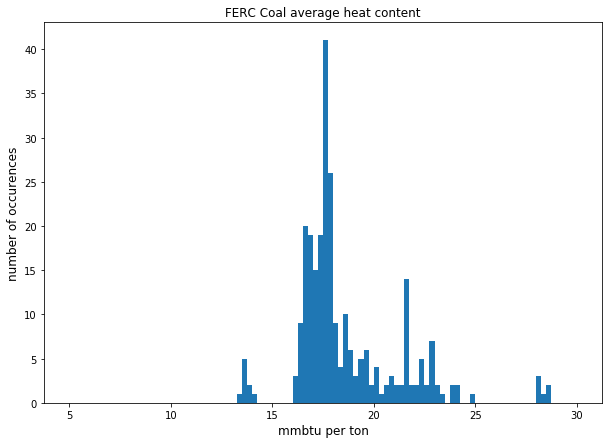

In [8]:
simplegraph(coal.fuel_avg_mmbtu_per_unit,'mmbtu per ton','number of occurences',\
           'FERC Coal average heat content',5,30)

There are two outlying populations: 
- one population around .01, which is off by a factor of 2000, as heat content is reported in mmbtu per pound rather than per ton
- one population around 2.0e-5, which is off by a factor of 1e6, as heat content is reported in btu per ton rather than mmbtu per ton.

We will apply the cleaning function and the showfix function to see how the data looks once the multipliers are applied:

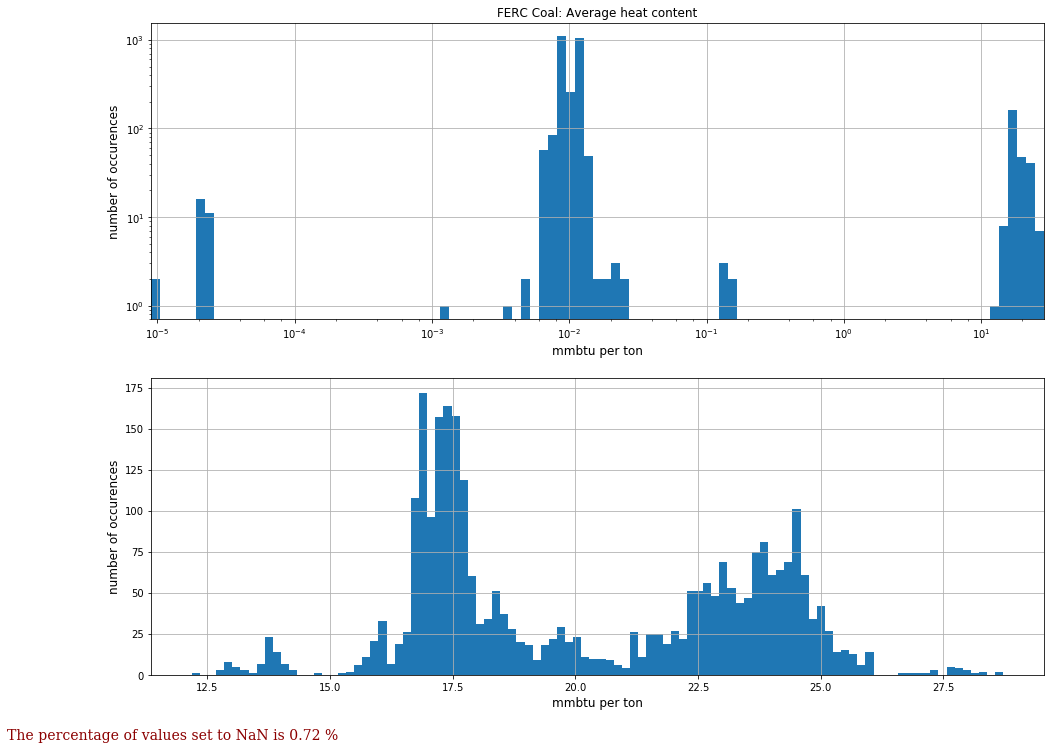

In [9]:
to_fix_avg_heat_content_coal = coal.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_coal = fixit(coal.fuel_avg_mmbtu_per_unit,10,29,[2000,1e6])

showfix(to_fix_avg_heat_content_coal,fixed_avg_heat_content_coal,'FERC Coal: Average heat content',\
        'mmbtu per ton','number of occurences')

There are two distinct humps within the cleaned dataset, one around 17 mmbtu per ton, corresponding to tons of lignite coal, and another around 24 mmbut per ton, corresponding to bituminous coal. 

### Average heat content of natural gas

As we turn our attention to natural gas, one expects to find the main population near 1 mmbtu per mcf (per EIA 2016 data https://www.eia.gov/dnav/ng/ng_cons_heat_a_epg0_vgth_btucf_a.htm). Looking at the data near 1, one finds the main population begins after .8 and ends before 1.25 mmbtu per mcf.

Natural gas heat contents are typically .95 mmbtu per mcf or greater (according to the EPA gross heat content values https://www3.epa.gov/ttnchie1/ap42/ch01/final/c01s04.pdf). Looking at EIA data on the heat content delivered to consumers (https://www.eia.gov/dnav/ng/ng_cons_heat_a_EPG0_VGTH_btucf_m.htm) one sees that gas heat content is typically above ~.95 mmbtu per mcf as well. The EIA writes that "Heat content of combustible energy forms can be expressed in terms of either gross heat content (higher or upper heating value) or net heat content (lower heating value), depending upon whether or not the available heat energy includes or excludes the energy used to vaporize water (contained in the original energy form or created during the combustion process). The Energy Information Administration typically uses gross heat content values." 

The EIA Form 923 instructions (https://www.eia.gov/survey/form/eia_923/instructions.pdf ask for heat content in gross heat content and include heating value ranges. The range for natural gas is .8 to 1.2 mmbtu per mcf - we'll use these values.

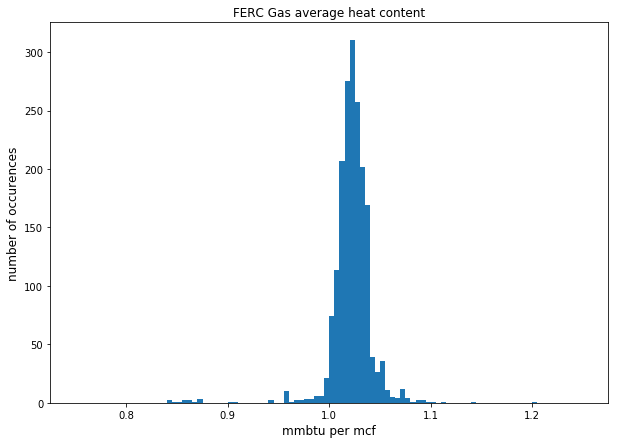

In [10]:
simplegraph(gas.fuel_avg_mmbtu_per_unit,'mmbtu per mcf','number of occurences',\
           'FERC Gas average heat content',.75,1.25)

There are two outlying populations: 
- one population around 1e-3, which is off by a factor of 1000, as heat content is reported in mmbtu per cubic foot rather than mmbtu per thousand cubic foot
- one population around 1e-6, which is off by a factor of 1e6, as heat content is reported in btu per mcf rather than mmbtu per mcf.

Let's again apply the cleaning function and the showfix function and take a look at the cleaned, combined distribution.

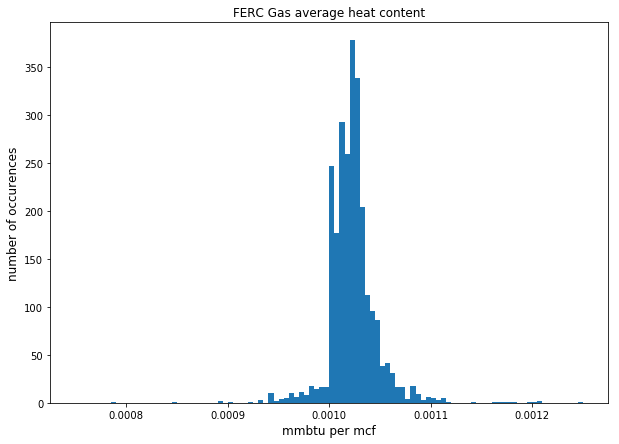

In [11]:
simplegraph(gas.fuel_avg_mmbtu_per_unit,'mmbtu per mcf','number of occurences',\
           'FERC Gas average heat content',.00075,.00125)

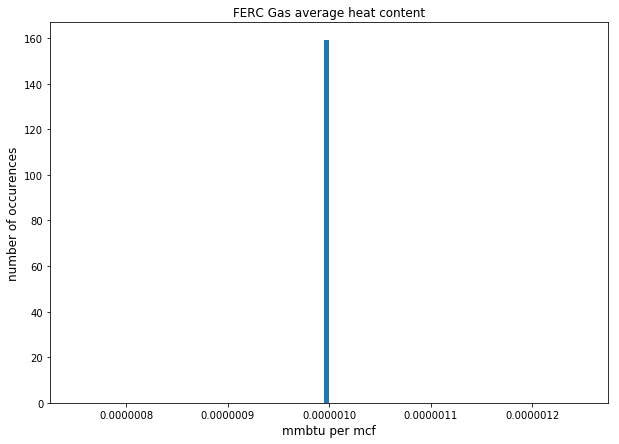

In [12]:
simplegraph(gas.fuel_avg_mmbtu_per_unit,'mmbtu per mcf','number of occurences',\
           'FERC Gas average heat content',.00000075,.00000125)

A small number of utilities reporting in btu per mcf rounded to .000001, creating a spike of ~150 values.

In [13]:
gas[(gas.fuel_avg_mmbtu_per_unit > 0) & (gas.fuel_avg_mmbtu_per_unit < .0000012)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
428,429,27,Dicks Creek Gt,2007,gas,mcf,4534.0,0.000001,9.602,0.000,9.340,27.0,0.0000
435,436,27,Fayette,2007,gas,mcf,4609161.0,0.000001,9.547,9.547,9.290,70.0,7.5070
436,437,27,Lee,2007,gas,mcf,563661.0,0.000001,8.829,8.829,8.590,110.0,12.2830
437,438,27,Washington,2007,gas,mcf,4900937.0,0.000001,9.450,9.450,9.190,70.0,7.4400
438,439,27,Vermillion,2007,gas,mcf,1591965.0,0.000001,5.534,5.534,5.380,70.0,13.4200
439,440,27,Hanging Rock,2007,gas,mcf,11971713.0,0.000001,9.832,9.832,9.560,70.0,7.5640
444,445,178,Woodsdale Gt,2007,gas,mcf,1780794.0,0.000001,8.002,8.002,7.784,235.0,30.3080
606,607,99,Eaton,2007,gas,mcf,301939.0,0.000001,7.665,0.000,7.515,113.0,15.0550
609,610,99,Watson,2007,gas,mcf,533399.0,0.000001,8.777,0.000,8.423,212.0,0.0000
610,611,99,Watson Ct,2007,gas,mcf,18435.0,0.000001,8.749,0.000,8.396,147.0,17.5430


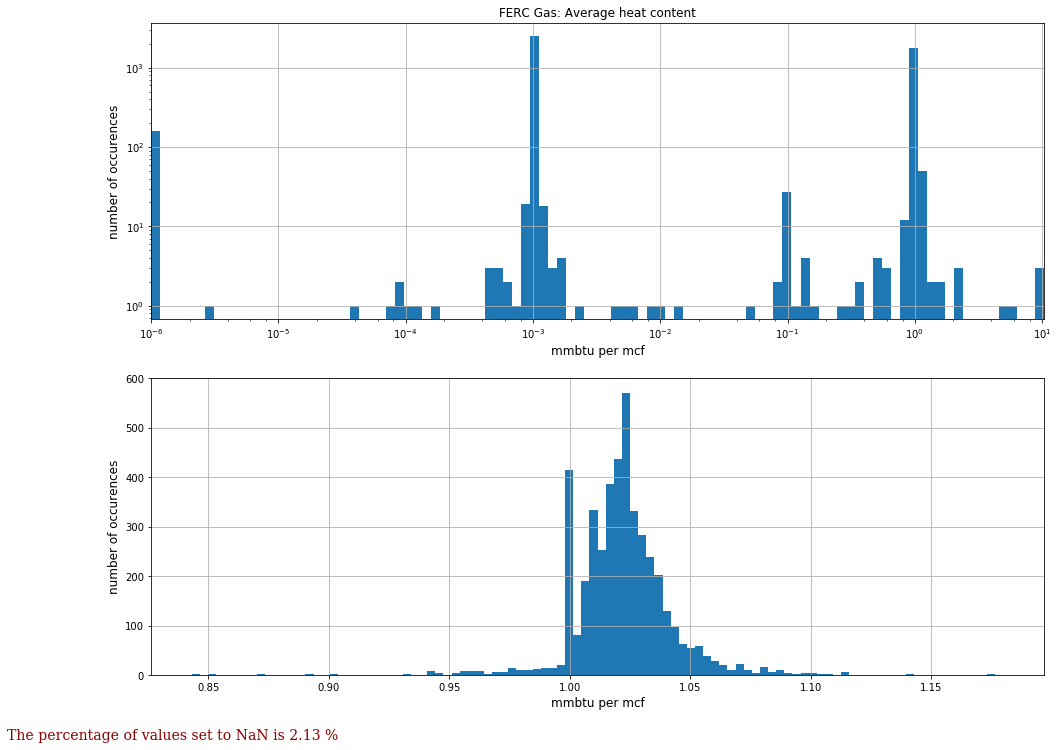

In [14]:
to_fix_avg_heat_content_gas = gas.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_gas = fixit(gas.fuel_avg_mmbtu_per_unit,.8,1.2,[1000,1e6])

showfix(to_fix_avg_heat_content_gas,fixed_avg_heat_content_gas,'FERC Gas: Average heat content',\
        'mmbtu per mcf','number of occurences')

The heat content per mcf, aside from the spike of rounded values (it appears many utilities round to 1) around 1.0 mmbtu per mcf, appears as we would expect it to appear given an average US natural gas heat content of just above one. We should note that some utilities entered mmbtu as their fuel units but there doesn't appear to alter their heat content values in a discernable way:

In [15]:
gas.fuel_unit.value_counts()

mcf      4563
mmbtu      75
bbl        18
gal        10
ton         1
Name: fuel_unit, dtype: int64

In [16]:
gas[gas.fuel_unit == 'mmbtu']

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
120,121,122,Huron Gt,2007,gas,mmbtu,33037.0,0.136500,7.028,7.028,23.218,219.0,0.031167
122,123,122,Yankton,2007,gas,mmbtu,7717.0,0.001000,8.136,8.136,10.864,236.0,7.575909
124,125,122,Huron Ct,2007,gas,mmbtu,62152.0,0.136500,7.362,7.362,45.755,92.0,0.012564
1046,1047,132,Solway,2007,gas,mmbtu,641808.0,0.638592,7.060,7.060,7.055,85.0,11.951000
1427,1428,122,Huron Gt,2008,gas,mmbtu,3386.0,0.001000,10490.000,10490.000,3.552,-296.0,-0.028217
1429,1430,122,Yankton,2008,gas,mmbtu,3062.0,0.001000,9.407,9.407,9.274,362.0,14.439371
1431,1432,122,Huron Ct,2008,gas,mmbtu,82230.0,0.001000,8.390,8.390,68.981,142.0,0.016923
1624,1625,132,Solway,2008,gas,mmbtu,546755.0,0.545600,8.290,8.290,8.290,97.0,11.652000
1656,1657,294,Wabash River Unit #1,2008,gas,mmbtu,9358849.0,0.000000,6.070,6.070,6.070,54.0,8.856000
1657,1658,294,Wabash River Unit #1,2008,gas,mmbtu,548000.0,0.000000,9.120,9.120,9.120,81.0,0.000000
